<a href="https://colab.research.google.com/github/CT-Cultures/Content/blob/master/RegOverview_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Drive
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# [1] Setting up Environment and Install Requirements

In [2]:
%%capture
!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

!pip install transformers

In [2]:
# Load Module
import os
import gc
import pandas as pd
from bs4 import BeautifulSoup
import re
import datetime 

from IPython.display import display, HTML

import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank
import jieba.posseg as pseg

import torch

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.font_manager as fm

path_fonts = '/content/drive/MyDrive/Github/Article/fonts'
fontprop = fm.FontProperties(fname=path_fonts, size= 15)

font_dirs = [path_fonts, ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
for font in font_files:
  fm.fontManager.addfont(font)

plt.rcParams['figure.figsize'] = [15, 9]
mp.rcParams['font.family'] = ['Microsoft YaHei']

%matplotlib inline

# Load Local Lib# Set Path
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

from sources.NRTA.Record_Registration import Registration # assume relative path at path_wd

tv_reg = Registration()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [3]:
# Set Path
path_records = '/content/drive/MyDrive/Github/Article/records'
# Set Path
path_wd = '/content/drive/MyDrive/Github/Article'
path_font = '/content/drive/MyDrive/Github/Article/fonts/STHUPO.TTF'
path_img = '/content/drive/MyDrive/Github/Article/img'
path_nrta = '/content/drive/MyDrive/Github/Content/sources/NRTA'

os.chdir(path_wd)

## 1.3 Load Latest Registration Publication

In [4]:
os.chdir(path_nrta)
##########################################

fp = '/content/drive/MyDrive/Github/Content/sources/NRTA/records/contents_of_registrations.json'
df = pd.read_json(fp)

In [5]:
curr_issue_dt = df['公示年月'].iloc[0]
issue_name = str(curr_issue_dt)
issue_name

'2021年10月'

In [6]:
# clean df, run mulitple times as necessary
df['许可证号'] = df['许可证号'].apply(lambda x:
                    x.lstrip('\n+').lstrip('\t+').lstrip('\w+').rstrip('\t+').rstrip('\n+'))
df['备注'] = df['备注'].apply(lambda x:
                    x.lstrip('\n+').lstrip('\t+').lstrip('\w+').rstrip('\t+').rstrip('\n+'))

In [7]:
df_curr = df[df['公示年月'] == curr_issue_dt].copy()
print(df_curr.columns)

Index(['剧名', '集数', '报备机构', '题材', '内容提要', '公示年月', '许可证号', '体裁', '拍摄日期', '制作周期',
       '省级管理部门备案意见', '相关部门意见', '备注', '备案链接', '公示名称', '公示批次链接', '地区'],
      dtype='object')


#[2] Load Model for Predictons


## [2.1] Extract top keywords

In [8]:
df_curr['kw'] = df_curr['内容提要'].apply(textrank, topK=10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.203 seconds.
Prefix dict has been built successfully.


In [9]:
df_curr['kw'].to_numpy()

array([list(['工作', '公司', '欣赏', '发现', '达到', '化解', '开发', '实则', '总经理', '智能']),
       list(['主题', '小朋友', '防护', '运动', '学会', '斑马', '好玩', '生活', '博士', '改造']),
       list(['饭店', '团圆', '跃进', '前夫', '直到', '服务', '夫妻', '生育', '离婚', '结为']),
       list(['质量', '孩子', '问题', '负责', '生活', '家人', '准备', '母亲', '造成', '停职']),
       list(['战斗', '解放', '人民政权', '土匪', '纵队', '黄河', '进入', '不了', '打击', '部队']),
       list(['球队', '女子', '危机', '化解', '篮球', '姑娘', '帮助', '传统', '找到', '消失']),
       list(['日方', '特工', '军统', '发展', '情报', '调查', '险遭不测', '寻求', '委派', '方面']),
       list(['高考', '梦想', '学生', '信任', '饱满', '迎接', '中学', '失败', '重回', '守护']),
       list(['间谍', '行动', '处长', '窃取', '情报', '拨开', '项目', '组织', '配合', '迷雾']),
       list(['家庭', '建业', '职场', '妻子', '心结', '公司', '决定', '经纪', '主播', '事业']),
       list(['三叉戟', '工作室', '青山', '犯罪集团', '警种', '传销案', '发现', '牵连', '能够', '案件']),
       list(['现代化', '梦想', '军营', '军人', '华阳', '强军', '军队', '离开', '原因', '时代']),
       list(['芯片', '海潮', '中国', '导航', '创业', '自主', '链断裂', '围绕', '资金', '推动']),
       list(

## [2.2] Load Title Prediction Model

In [10]:
%%capture
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint)
model.to(device)
model.eval()

In [11]:
batch_size = 8
i = 0
ls = df_curr['内容提要'].tolist()
L = df_curr.shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

In [12]:
df_curr['预测剧名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  x = re.sub('\[UNK\]', '', x)
  return x

df_curr['预测剧名'] = df_curr['预测剧名'].apply(remove_specials)

In [13]:
df_curr['预测剧名'].to_numpy()

array(['职场恋情', '狐狸小镇', '团圆饭店', '柴米油盐', '黄河纵队', '篮球女王', '地下特工', '我的少年时代',
       '绝密行动', '男主外女主内', '三叉戟', '军魂', '海上芯片', '创意部总监', '尚天宝传奇', '青春向上',
       '乡村振兴之路', '环保案件', '烽火武汉', '徐谓礼文书', '老乡们', '有风小院', '火漫云', '勇猛之师',
       '律师事务所', '杏花村的故事', '我的酒店女友', '书场', '无忧面包店', '第十一个文明经营户', '沂蒙山小调',
       '红旗不倒', '弯树岭的故事', '三六九', '鸡公福', '大院街坊', '黑旋行动', '十七岁你喜欢谁', '篮球少年',
       '冲浪少年', '家好月圆'], dtype=object)

## [2.3] 识别主要角色

In [14]:
df_curr['time'] = df_curr['题材'].apply(lambda x: x[0:2])
df_curr['genre'] = df_curr['题材'].apply(lambda x: x[2:])

df_curr['制作周期_月'] = df_curr['制作周期'].apply(lambda x: int(x.rstrip('个月')))

def months_to_principal_photography(x: pd.Series):
  year = int(x.split('.')[0])
  month = int(x.split('.')[1])
  now = datetime.datetime.now()
  p_date = datetime.date(year, month, 15)
  months_from_now = (p_date - now.date()).days // 30
  return months_from_now

df_curr['距离开机'] = df_curr['拍摄日期'].apply(months_to_principal_photography)
#df_curr['预估拍摄速度'] = df_curr['制作周期_月'] / df_curr['集数']*30

In [15]:
import jieba
import jieba.posseg as pseg
jieba.enable_paddle() #启动paddle模式。 0.40版之后开始支持，早期版本不支持

Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......


In [16]:
# 识别主要角色
def find_PER(x: pd.Series):
  words = pseg.cut(x, use_paddle=True)
  ls_PER = []
  for word, flag in words:
    if flag == 'PER':
      word = word.strip('[\s,，。、“”？；]')
      ls_PER.append(word)
  ls_PER = list(set(ls_PER))

  ls_PER1 = ls_PER.copy()
  ls_PER = []
  while ls_PER1:
    PER =  ls_PER1.pop(0)
    ls_tmp = re.split('[\s,，。、“”？；]', PER)
    ls_PER.extend(ls_tmp)

  ls_PER = list(set(ls_PER)) 
  ls_PER = [PER for PER in ls_PER if len(PER) > 1]
  ls_PER_sorted = sorted(ls_PER, reverse=False, key=lambda x: len(x))

  ans = []
  while ls_PER_sorted:
    PER = ls_PER_sorted.pop(0)
    i = 0
    while i < len(ls_PER_sorted):
      if re.search(PER, ls_PER_sorted[i]):
        ls_PER_sorted.pop(i)
        ans.append(PER)
      i += 1
    if PER not in ans:
      ans.append(PER)

  return ans

df_curr['主要角色'] = df_curr['内容提要'].apply(find_PER)

In [17]:
df_curr['主要角色'].to_numpy()

array([list(['周琛海', '李思采']), list(['小鳄']),
       list(['哈红', '刘跃', '孙家国', '孙无双']),
       list(['柴明志', '尤美琪', '接风宴', '柴明炀', '米芳华']),
       list(['耿县', '连捷', '王成瑞', '胡宗南', '阎锡山']),
       list(['韩夏', '陈伯宇', '陈柏宇']),
       list(['项所', '谭顾', '徐耀祖', '顾知非', '项童霄', '谭世宁']), list(['郝楠', '任真']),
       list(['褚处长']), list(['花暮云', '苏建业']),
       list(['小吕', '徐蔓', '郭局', '周茂', '崔铁军', '徐国柱', '潘江海']),
       list(['严伟', '杜天宇', '张华阳', '小叶子', '何泽明', '王大壮', '李汉超']),
       list(['布莱恩', '黎东升', '张海潮']), list(['周游', '程信', '钟盈欣']),
       list(['尚天宝', '尚天秀', '尚天锦', '晋绥军', '尚宏德']),
       list(['周齐', '齐平', '杨絮', '许怀谷', '周铁军', '万小异']),
       list(['杨九妹', '金九妹', '刘九妹']), list(['罗远', '耿念', '夏未冬']), list([]),
       list(['周易']), list(['铁森', '肖悦', '李哲', '艾峰']), list(['许红豆', '谢之遥']),
       list(['唐震', '丁自强', '火漫云']), list(['景仁', '蒋策', '尤德耀']),
       list(['马伟', '甄小佳']), list(['杜鹃', '郭玉强']),
       list(['乐林', '卫风', '田苗', '林西北']), list(['曦南', '张琴琴', '方末交往']),
       list(['小满', '谢莹', '孙晓楠', '陈乐天', '欧阳晟懿']

## 调整类型

In [18]:
df_curr['类型'] = df_curr['genre'].copy()

In [19]:
df_curr['genre'].to_numpy()

array(['都市', '青少', '都市', '都市', '革命', '青少', '其它', '都市', '涉案', '都市', '涉案',
       '军旅', '都市', '都市', '传奇', '其它', '农村', '涉案', '都市', '涉案', '其它', '其它',
       '都市', '军旅', '都市', '农村', '都市', '都市', '青少', '都市', '革命', '革命', '农村',
       '都市', '都市', '都市', '军旅', '都市', '其它', '都市', '都市'], dtype=object)

In [21]:
genre_v2 = ['喜剧', '爱情', '动作', '犯罪', '科幻', '奇幻', '冒险', '灾难', '恐怖',
 '惊悚', '剧情', '战争', '歌舞', '悬疑', '动画', '同性']

genre_v2 +=  ['商战', '青少', '家庭', '宅斗', '战争', '体育', '谍战', '涉案', '军旅', '职业', '传奇', '宫斗']
genre_v2 +=  ['职业', '商战', '体育', '涉案']
genre_v2 +=  ['科幻', '奇幻', '冒险', '神话', '仙侠']
genre_v2 +=  ['历史', '宫廷', '宫斗', '宅斗', '传奇']
genre_v2 +=  ['革命', '战争', '军旅']
genre_v2 +=  ['都市', '农村']
genre_v2 +=  ['爱情', '喜剧', '惊悚', '恐怖', '歌舞']
genre_v2 +=  ['灾难']
genre_v2 +=  ['青少']
genre_v2 +=  ['其它']

genre_v2 = list(set(genre_v2))

In [22]:
df_curr['类型'] = ['商战', '青少', '家庭', '家庭', '战争', '体育', '谍战', '青少', '涉案', '家庭', '涉案',
       '军旅', '商战', '职业', '传奇', '体育', '农村', '涉案', '职业', '涉案', '剧情', '剧情',
       '职业', '军旅', '职业', '农村', '剧情', '剧情', '青少', '剧情', '革命', '战争', '农村',
       '剧情', '剧情', '剧情', '谍战', '剧情', '体育', '体育', '家庭']

In [ ]:
HTML(df_curr[['剧名', 'genre', '内容提要']].to_html())

# [2] Generating Article Contents

##[2.1] 2021年X月电视剧备案划重点

In [24]:
# Title
T1 = '{}电视剧备案划重点'.format(df_curr['公示年月'].iloc[0])

print(T1)

2021年10月电视剧备案划重点


In [25]:
dfview = df_curr[[
                   '剧名', '集数', '距离开机', '类型', 
                   'time', '主要角色', '报备机构', '内容提要',
                   '预测剧名', 'kw']].sort_values('距离开机')
dfview.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 1 to 0
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   剧名      41 non-null     object
 1   集数      41 non-null     int64 
 2   距离开机    41 non-null     int64 
 3   类型      41 non-null     object
 4   time    41 non-null     object
 5   主要角色    41 non-null     object
 6   报备机构    41 non-null     object
 7   内容提要    41 non-null     object
 8   预测剧名    41 non-null     object
 9   kw      41 non-null     object
dtypes: int64(2), object(8)
memory usage: 3.5+ KB


## 按类型划分

<Figure size 432x288 with 0 Axes>

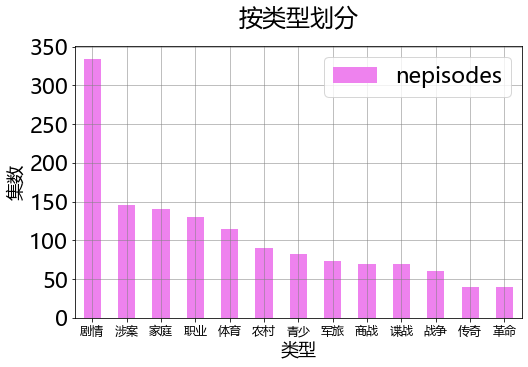

In [26]:
df_by_genre_episode = \
  dfview.groupby('类型')['集数'].sum().rename('nepisodes'
  ).reset_index().sort_values('nepisodes', ascending=False)

plt.clf()
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['axes.facecolor'] = 'white'
ax = df_by_genre_episode.plot(
    kind = 'bar',
    grid = True,
    fontsize = 22,
    rot = 0,
    color = ['violet'],
)
ax.set_title("按类型划分",fontsize= 24, pad=20)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('类型',fontsize= 18)
ax.set_xticklabels(df_by_genre_episode['类型'], fontsize=12)
ax.set_ylabel("集数",fontsize= 18)
ax.legend(fontsize=22)

fp_plot_time = path_img + '/df_TVReg_plot_genre_by_nepisodes_{}.png'.format(issue_name)
plt.savefig(fp_plot_time, bbox_inches='tight')

plt.show()

<Figure size 576x360 with 0 Axes>

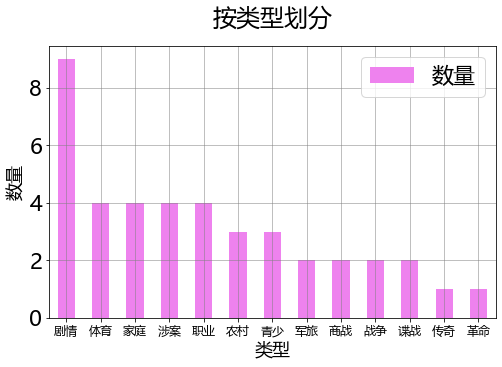

In [27]:
# WIP
df_by_genre= dfview.groupby('类型')['类型'].count(
    ).rename('数量').reset_index().sort_values('数量', ascending=False)

plt.clf()
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['axes.facecolor'] = 'white'
ax = df_by_genre.plot(
    kind = 'bar',
    grid = True,
    fontsize = 22,
    rot = 0,
    color = ['violet'],
)
ax.set_title("按类型划分",fontsize= 24, pad=20)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('类型',fontsize= 18)
ax.set_xticklabels(df_by_genre['类型'], fontsize=12)
ax.set_ylabel("数量",fontsize= 18)
ax.legend(fontsize=22)

fp_plot_time = path_img + '/df_TVReg_plot_genre_by_n_{}.png'.format(issue_name)
plt.savefig(fp_plot_time, bbox_inches='tight')

plt.show()

##[2.2] 	本期通过备案的电视剧共计39部,估计已开机的1部,一个月内将开机的20部,距离开机一个月以上的18部。其中，20集(含）以下的电视剧又4部,20到40集的有35部,超过40集的有0部。


In [28]:
dfview.columns
dfview['集数'] = dfview['集数'].astype('int')

In [29]:
# Write Content
T2 = '\n'
T2 += '本期通过备案的电视剧共计{}部，'.format(dfview.shape[0])
T2 += '估计已开机的{}部，'.format(dfview[dfview['距离开机'] < 0].shape[0])
T2 += '一个月内将开机的{}部，'.format(
    dfview[(dfview['距离开机'] >= 0) & (dfview['距离开机'] < 2)].shape[0])

T2 += '距离开机一个月以上的{}部。'.format(
    dfview[(dfview['距离开机'] > 2)].shape[0])

T2 += '其中，20集(含）以下的电视剧有{}部，'.format(dfview[dfview['集数'] <= 20].shape[0])
T2 += '20到40集的有{}部，'.format(
    dfview[(dfview['集数'] > 20) & (dfview['集数'] <= 40)].shape[0])
T2 += '超过40集的有{}部。'.format(dfview[dfview['集数'] > 40].shape[0])

print(T2)


本期通过备案的电视剧共计41部，估计已开机的7部，一个月内将开机的13部，距离开机一个月以上的18部。其中，20集(含）以下的电视剧有3部，20到40集的有38部，超过40集的有0部。


##[2.3] 	本批次中，大数据分析识别出XX部上市影视公司关联项目，占比XX%。慷田AI聚焦关注的有

In [ ]:
HTML(df_curr[['剧名', '题材', '报备机构', '内容提要']].to_html())

In [30]:
df_curr['报备机构'].unique()

array(['北京盈凯传媒发展有限公司', '北京君舍文化传媒有限公司', '北京一和云方影视文化有限公司', '北京灿影文化传媒有限公司',
       '九州升平（北京）文化传媒有限公司', '北京弘视际影业股份有限公司', '北京完美世界影视有限公司',
       '北京欢乐源泉影视传媒有限公司', '北京领骥影视文化股份有限公司', '天津天马映像影业有限公司',
       '上海上象星作娱乐（集团）股份有限公司', '上海尚世影业有限公司', '上海阅新影视文化有限公司', '山西若菁文化传媒有限公司',
       '山西广播电视台', '黑龙江昊雁文化传媒有限公司', '苏州蓝白红影业有限公司', '东阳金百星影视文化传播有限公司',
       '浙江鼎叙辉煌文化发展有限责任公司', '浙江影视（集团）有限公司', '华策（厦门）影视有限公司',
       '晋江市星势力文化传播有限公司', '福建海域影业有限公司', '江西电视剧制作有限公司', '青岛山海聚星影业有限公司',
       '中基久杭（青岛）影视文化有限公司', '山东摩曦映画文化传媒有限公司', '青岛鲸屿万泽文化传媒有限公司',
       '临沂市夸克文化传媒有限公司', '山东卫视传媒有限公司', '河南天涌太行影视节目制作有限公司', '京山毓秀影视传媒有限公司',
       '广东珠江电影集团有限公司', '广西元鼎文化传播有限公司', '宇乐乐（海南）影视文化有限公司',
       '海朔影视文化传媒（海南）有限公司', '陕西叶绿素影业有限公司'], dtype=object)

In [31]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Article/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店|华策|电视剧制作中心'
pat_public += '|得闲|芒果|新丽|欢乐|尚世|华策|稻草熊|东阳欢娱|耀客|湖南快乐阳光|山东影视制作|当代时光'
pat_public += '|唐德|欢瑞|优酷|嘉行|东阳欢愉|稻草熊|天马映像'
df_focus = dfview.loc[dfview['报备机构'].str.contains(pat_public), :]
df_focus[['剧名','报备机构', '集数','内容提要', '类型']]

,剧名,报备机构,集数,内容提要,类型
34,七十二家房客第十八部（上篇）,广东珠江电影集团有限公司,40,随着时势动荡，太子炳、八姑的资产大为缩水，逐渐变得外强中干，万幸的是炳盛大押及部分业务得以维...,剧情
33,七十二家房客第十八部（下篇）,广东珠江电影集团有限公司,40,阿兰到牛局长家里当佣人，阿瑞在孙锦珍舞厅兼职做杂役，本来只是想多赚一份维持生计的饭钱，但却没...,剧情
12,纵横芯海,上海尚世影业有限公司,40,装有科宝导航仪的渔船在海上失踪，张海潮靠高超的心算能力克服了技术问题，却还是未能避免渔民的悲...,商战
7,灿烂！灿烂！,北京完美世界影视有限公司,32,离开教育行业五年的郝楠，在经营店铺失败后，重回教师岗位。十八岁的任真因不靠谱的父亲导致高考落...,青少
35,七十二家房客第十八部（中篇）,广东珠江电影集团有限公司,40,为了追求更美好的生活，鸡公福与发仔共同谋划如何将咸杂铺经营得更好。婚后玉嫂看不得丈夫在大小事...,剧情
21,去有风的地方,华策（厦门）影视有限公司,40,许红豆因为闺蜜去世，生活和工作陷入低谷，她独自前往大理云苗村的“有风小院”休息调整。在那里，...,剧情
8,破晓行动,北京欢乐源泉影视传媒有限公司,30,域外敌对势力启动对我国一个绝密项目的情报窃取计划，同时调动间谍组织，针对我国不同领域开展多轮...,涉案
10,三叉戟2,天津天马映像影业有限公司,36,号称市局“三叉戟”的崔铁军、徐国柱和潘江海在侦破一起传销案时，发现关键嫌疑人和二十年前一桩凶...,涉案


In [32]:
ids = [7,12,34,35,33,21,10]
df_focus_narrowed = df_focus.loc[ids]

In [33]:
df_focus_narrowed['单位简称'] = df_focus_narrowed['报备机构'].str.extract('('+ pat_public + ")")

In [34]:
df_focus_narrowed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 7 to 10
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   剧名      7 non-null      object
 1   集数      7 non-null      int64 
 2   距离开机    7 non-null      int64 
 3   类型      7 non-null      object
 4   time    7 non-null      object
 5   主要角色    7 non-null      object
 6   报备机构    7 non-null      object
 7   内容提要    7 non-null      object
 8   预测剧名    7 non-null      object
 9   kw      7 non-null      object
 10  单位简称    7 non-null      object
dtypes: int64(2), object(9)
memory usage: 672.0+ bytes


In [35]:
########
T3 = '\n'
T3 += '本批次中，ContentAI识别出{}部上市影视公司及国资参投影视公司关联项目，'.format(df_focus.shape[0])
T3 += '占比{}%。'.format(round((df_focus.shape[0]/df_curr.shape[0]*100),2))
T3 += '结合题材与出品方实力，ContentAI聚焦关注的有'

for i, row in df_focus_narrowed.iterrows():
  T3 += '{}的'.format(row['单位简称'])
  if i == df_focus_narrowed.index[-2]:
    T3 += '《{}》和'.format(row['剧名'])
  else:
    T3 += '《{}》、'.format(row['剧名'])
T3 = T3.rstrip('、') + '，'

T3 += '题材类型包括了{}。\n'.format(
    '、'.join(df_focus_narrowed['类型'].unique())
)
print(T3)


本批次中，ContentAI识别出8部上市影视公司及国资参投影视公司关联项目，占比19.51%。结合题材与出品方实力，ContentAI聚焦关注的有完美的《灿烂！灿烂！》、尚世的《纵横芯海》、珠江的《七十二家房客第十八部（上篇）》、珠江的《七十二家房客第十八部（中篇）》、珠江的《七十二家房客第十八部（下篇）》、华策的《去有风的地方》和天马映像的《三叉戟2》，题材类型包括了青少、商战、剧情、涉案。



In [36]:
df_focus_narrowed.index[-2]

21

## [2.4] 生成词云图

In [37]:
df_focus_narrowed.index

Int64Index([7, 12, 34, 35, 33, 21, 10], dtype='int64')

In [38]:
os.chdir(path_wd)
#%load_ext autoreload
%reload_ext autoreload
from generate import utils

from IPython.display import Image as Img
from PIL import Image as pil
path_img = '/content/drive/MyDrive/Github/Article/img'

/content/drive/MyDrive/Github/Article/generate/utils.py:21: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)
Paddle enabled successfully......


In [55]:
from IPython.display import Image as Img
from PIL import Image as pil

path_posters = '/content/drive/MyDrive/Github/Article/img/posters'
path_icon = '/content/drive/MyDrive/Github/Article/img/genre_icon'

#df_label2image.to_json(path_records + '/df_label2image.json')
df_label2image = pd.read_json(path_wd + '/records/df_label2img.json')

In [54]:
df_label2image.loc[27,:] = ['商战', 'swan-46510_1280.png']
df_label2image.loc[28,:] = ['战争','explosion.png']
df_label2image.loc[29,:] = ['体育', 'goalkeeper-294327_1280.png']
df_label2image.loc[30,:] = ['谍战', 'butterfly-47967_1280.png']

In [ ]:
df_label2image

In [56]:
df_focus_narrowed['src_img'] = None
df_focus_narrowed['tgt_img'] = None

In [58]:
for i in df_focus_narrowed.index:
  ls = [df_focus_narrowed.loc[i, '剧名']] * 10
  ls += [df_focus_narrowed.loc[i, '预测剧名']] *6
  ls += df_focus_narrowed.loc[i, '主要角色']*3
  ls += [df_focus_narrowed.loc[i, '类型']] *3
  ls += [df_focus_narrowed.loc[i, 'time']]*3
  ls += df_focus_narrowed.loc[i, 'kw']
  img_fn = df_focus_narrowed.loc[i, 'src_img']
  if not img_fn:
    img_fn = df_label2image.loc[
        df_label2image['label'] == df_focus_narrowed.loc[i, '类型'],
        'fn'
    ].iloc[0]
  #print(txt)
  fp_img = path_img + '/genre_icon/{}'.format(img_fn)
  fp_mask = path_img + '/genre_icon/{}'.format('mask_' + img_fn)
  #fp_img = path_img + '/genre_icon/{}'.format('psychedelic-1084082_960_720.jpg')
  fp_generated_img = utils.generate_word_image(ls, 
                                               fp_img, 
                                               fp_mask,
                                               fp_prefix='NRTA_TVReg_Overview',
                                               fp_suffix=issue_name,
                                               img_width=400,
                                               )
  #display(Img(fp_generated_img, width=400))
  df_focus_narrowed.loc[i, 'tgt_img'] = fp_generated_img

Output hidden; open in https://colab.research.google.com to view.

##[2.5] 生成摘要

In [60]:
S0 = issue_name
S0 += '电视剧备案慷田AI聚焦关注的有'

for i, row in df_focus_narrowed.iterrows():
  S0 += '{}的'.format(row['单位简称'])
  if i == df_focus_narrowed.index[-2]:
    S0 += '《{}》和'.format(row['剧名'])
  else:
    S0 += '《{}》、'.format(row['剧名'])
S0 = S0.rstrip('、') + '，'

S0 += '题材类型包括了{}。\n'.format(
    '、'.join(df_focus_narrowed['类型'].unique())
)
print(S0)

2021年10月电视剧备案慷田AI聚焦关注的有完美的《灿烂！灿烂！》、尚世的《纵横芯海》、珠江的《七十二家房客第十八部（上篇）》、珠江的《七十二家房客第十八部（中篇）》、珠江的《七十二家房客第十八部（下篇）》、华策的《去有风的地方》和天马映像的《三叉戟2》，题材类型包括了青少、商战、剧情、涉案。



##[2.6] 指向国家广电局官网


In [61]:
#####
R1 = '\n\n'
R1 += 'ContentAI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
R1 += '电视剧备案公示信息来自国家广播电视总局 National Radio and Televison Administration, 官方网址 '
R1 += ' http://www.nrta.gov.cn/ 。'

print(R1)



ContentAI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。电视剧备案公示信息来自国家广播电视总局 National Radio and Televison Administration, 官方网址  http://www.nrta.gov.cn/ 。


In [70]:
R2 = '点击左下角阅读原文查看本期ContentAI电视剧信息详表。'
R3 = '点击左下角阅读原文查看本期ContentAI电视剧概览分析。'

In [63]:
issue_name

'2021年10月'

## [2.7] Save df of this issue pickle

In [71]:
df_curr.to_pickle(path_records + '/df_tvreg_{}.pkl'.format(issue_name))
df_focus_narrowed.to_pickle(path_records + '/df_tvreg_focus_{}.pkl'.format(issue_name))

In [72]:
df_curr = pd.read_pickle(path_records + '/df_tvreg_{}.pkl'.format(issue_name))
df_focus_narrowed = pd.read_pickle(path_records + '/df_tvreg_focus_{}.pkl'.format(issue_name))

#[3] Output Word Document

## 3.1 Install and Load Libraries

In [65]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

In [66]:
df_focus_narrowed[['报备机构']]

,报备机构
7,北京完美世界影视有限公司
12,上海尚世影业有限公司
34,广东珠江电影集团有限公司
35,广东珠江电影集团有限公司
33,广东珠江电影集团有限公司
21,华策（厦门）影视有限公司
10,天津天马映像影业有限公司


## 3.2 Output Docx


In [67]:
from docx import Document
from docx.shared import Inches
from docx.oxml.ns import qn

### Write Overview docx

In [78]:
path_doc = '/content/drive/MyDrive/Github/Article/docx'
path_img = '/content/drive/MyDrive/Github/Article/img'

doc = Document()

# Set document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Set Document Title
doc.core_properties.title = 'China TV Registration Overview ' + issue_name

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(T2)

doc.add_picture(fp_plot_time, width=Inches(6))
doc.add_paragraph(T3)

for i, row in df_focus_narrowed.iterrows():
  if  row['距离开机'] <= 0: pstatus = '估摸着已开机'
  elif  0 < row['距离开机'] <= 1: pstatus = '预计一个月内开机'
  else: pstatus = '预计距离开机1个月以上' 
  txt = '\n《{}》，{}集，{}。'.format(row['剧名'], row['集数'], pstatus)
  txt += '\n报备机构：{}'.format(row['报备机构'])
  txt += '\n主要角色：{}'.format('、'.join(row['主要角色']))
  doc.add_paragraph(txt)
  doc.add_picture(row['tgt_img'], width =Inches(4))
  doc.add_paragraph(row['内容提要'])

doc.add_paragraph(R1)
doc.add_paragraph(R2)

fp_doc = path_doc + '/TVregHighlight_' + issue_name + '.docx'
doc.save(fp_doc)


In [79]:
# Download Document
from google.colab import files
files.download(fp_doc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### write Table docx

In [ ]:
dfview.columns

Index(['剧名', '集数', '距离开机', 'genre', 'time', '主要角色', '报备机构', '内容提要', '预测剧名',
       'kw'],
      dtype='object')

In [76]:
doc = Document()

# Set document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Set Document Title
doc.core_properties.title = 'China TV Registration Table ' + issue_name

doc.add_heading('详表：{}'.format(T1), 0)

p = doc.add_paragraph(S0, style='Intense Quote')

table = doc.add_table(rows=1, cols=1, style='Light List Accent 3')
i = 1
for _, row in dfview.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[{}] '.format(i) + \
                      '《{}》，'.format(row['剧名']) + \
                      '{}集'.format(row['集数'])

  #if row['匹配片名'] != '':
  #  row_cells[0].text += ' (原备案名《{}》)'.format(row['匹配片名'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['time'] + row['类型']
  
  if  row['距离开机'] <= 0: pstatus = '估摸着已开机'
  elif  0 < row['距离开机'] <= 1: pstatus = '预计一个月内开机'
  else: pstatus = '预计{}个月后开机'.format(row['距离开机'])
  row_cells = table.add_row().cells
  row_cells[0].text = pstatus
  #if row['是否修改'] == '是':
  #  row_cells[0].text += ', 修改后通过备案'

  row_cells = table.add_row().cells
  row_cells[0].text = '报备机构: {}'.format(row['报备机构'])

  row_cells = table.add_row().cells
  row_cells[0].text = '主要角色: {}'.format('、'.join(row['主要角色']))

  row_cells = table.add_row().cells
  row_cells[0].text = row['内容提要']

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

doc.add_paragraph(R1)
doc.add_paragraph(R3)

fp_doc = path_doc + '/TVregTable_' + issue_name + '.docx'
doc.save(fp_doc)


In [77]:
# Download Document
from google.colab import files
files.download(fp_doc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>